In [1]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [2]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

maxcapacityfor_spp = 90
maxcapacityfor_vspp = 10

radius_spp_wind = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_wind * 3.14)) / 100,5)
radius_vspp_wind = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_wind * 3.14)) / 100,5)

radius_spp_solar = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_solar * 3.14)) / 100,5)
radius_vspp_solar = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_solar * 3.14)) / 100,5)

suitablearea_biomass = 150 ## km2
suitablearea_bgec = 150 ## km2
suitablearea_msw = 150 ## km2

print('radius_spp_wind km = ',radius_spp_wind*100,' buffer = ',radius_spp_wind)
print('radius_vspp_wind km = ',radius_vspp_wind*100,' buffer = ',radius_vspp_wind)
print('radius_spp_solar km = ',radius_spp_solar*100,' buffer = ',radius_spp_solar)
print('radius_vspp_solar km = ',radius_vspp_solar*100,' buffer = ',radius_vspp_solar)

radius_spp_wind km =  2.524  buffer =  0.02524
radius_vspp_wind km =  0.8410000000000001  buffer =  0.00841
radius_spp_solar km =  1.3820000000000001  buffer =  0.01382
radius_vspp_solar km =  0.461  buffer =  0.00461


In [3]:
scenario_SI = 0

xr_out = xr.open_dataset('Output\\xr_output_all_scenario_SI_' + str(scenario_SI) + '_.nc')
print(xr_out)
print("cap_wind = ",xr_out['cap_wind'].sum())
print("cap_solar = ",xr_out['cap_solar'].sum())
print("cap_biomass = ",xr_out['cap_biomass'].sum())
print("cap_bgec = ",xr_out['cap_bgec'].sum())
print("cap_msw = ",xr_out['cap_msw'].sum())

<xarray.Dataset>
Dimensions:      (lat: 534, lon: 298)
Coordinates:
  * lat          (lat) float64 5.628 5.656 5.683 5.711 ... 20.38 20.41 20.43
  * lon          (lon) float64 97.36 97.39 97.41 97.44 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 ...
    SI_Biomass   (lat, lon) float64 ...
    SI_Solar     (lat, lon) float64 ...
    SI_Wind      (lat, lon) float64 ...
    SI_MSW       (lat, lon) float64 ...
    ...           ...
    region       (lat, lon) object ...
    cap_wind     (lat, lon) float64 ...
    cap_solar    (lat, lon) float64 ...
    cap_biomass  (lat, lon) float64 ...
    cap_bgec     (lat, lon) float64 ...
    cap_msw      (lat, lon) float64 ...
cap_wind =  <xarray.DataArray 'cap_wind' ()>
array(9931.)
cap_solar =  <xarray.DataArray 'cap_solar' ()>
array(1200907.7)
cap_biomass =  <xarray.DataArray 'cap_biomass' ()>
array(2122.7)
cap_bgec =  <xarray.DataArray 'cap_bgec' ()>
array(0.)
cap_msw =  <x

In [4]:
df_wind = xr_out.to_dataframe()
xr_out.close()
df_wind.reset_index(inplace=True)
df_wind = gpd.GeoDataFrame(df_wind, geometry =gpd.points_from_xy(df_wind['lon'],df_wind['lat']))
df_wind.crs = {'init': 'epsg:4326'}
print(len(df_wind))
for i,c in enumerate(df_wind.columns):
    if c not in (['lon','lat','SI_Wind','SI_Wind_max','SI_Wind_min','region','ADM1_EN','cap_wind','AVA_Wind','geometry']):
        df_wind = df_wind.drop(columns=c)

df_wind = df_wind.loc[df_wind['cap_wind'] > 0]
df_wind.reset_index(inplace=True,drop=False)
df_wind.crs = {'init': 'epsg:4326'}
df_wind['buffer'] = df_wind['geometry'].buffer(np.round(np.sqrt(df_wind['cap_wind']/(mwperkm2_wind * 3.14)) / 100,5),cap_style = 3)
df_wind = df_wind.set_geometry('buffer')

df_wind.to_csv('Output\\Output_wind_all_scenario_SI_' + str(scenario_SI) + '.csv',index=False,encoding="utf-8-sig")

print(df_wind)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


       index        lat         lon   SI_Wind  AVA_Wind     ADM1_EN region  \
0       7884   6.350000  101.136111  0.059314      0.45        Yala     R3   
1       8182   6.377778  101.136111  0.385140      2.70        Yala     R3   
2       8777   6.433333  101.108333  0.251942      1.80        Yala     R3   
3       8778   6.433333  101.136111  0.809955      5.49        Yala     R3   
4       8785   6.433333  101.330556  0.037084      0.27        Yala     R3   
...      ...        ...         ...       ...       ...         ...    ...   
1942  137198  18.405556  100.636111  0.256800      2.25         Nan     R4   
1943  143170  18.961111  100.969444  0.079333      0.72         Nan     R4   
1944  149991  19.600000  100.052778  0.141823      1.17  Chiang Rai     R4   
1945  151457  19.738889   99.386111  0.046159      0.45  Chiang Rai     R4   
1946  152938  19.877778   99.136111  0.307227      2.88  Chiang Rai     R4   

      cap_wind                    geometry  \
0          2.0   

C:\Users\EGAT\AppData\Local\Temp\ipykernel_8960\31956592.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_wind['buffer'] = df_wind['geometry'].buffer(np.round(np.sqrt(df_wind['cap_wind']/(mwperkm2_wind * 3.14)) / 100,5),cap_style = 3)


In [5]:
df_solar = xr_out.to_dataframe()
df_solar.reset_index(inplace=True)
df_solar = gpd.GeoDataFrame(df_solar, geometry =gpd.points_from_xy(df_solar['lon'],df_solar['lat']))
df_solar.crs = {'init': 'epsg:4326'}
print(len(df_solar))
for i,c in enumerate(df_solar.columns):
    if c not in (['lon','lat','SI_Solar','SI_Solar_max','SI_Solar_min','region','ADM1_EN','cap_solar','AVA_Solar','geometry']):
        df_solar = df_solar.drop(columns=c)

df_solar = df_solar.loc[df_solar['cap_solar'] > 0]
df_solar.reset_index(inplace=True,drop=False)
df_solar.crs = {'init': 'epsg:4326'}
df_solar['buffer'] = df_solar['geometry'].buffer(np.round(np.sqrt(df_solar['cap_solar']/(mwperkm2_solar * 3.14)) / 100,5),cap_style = 3)
df_solar = df_solar.set_geometry('buffer')

df_solar.to_csv('Output\\Output_solar_all_scenario_SI_' + str(scenario_SI) + '.csv',index=False,encoding="utf-8-sig")

print(df_solar)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_8960\1997959653.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_solar['buffer'] = df_solar['geometry'].buffer(np.round(np.sqrt(df_solar['cap_solar']/(mwperkm2_solar * 3.14)) / 100,5),cap_style = 3)


        index        lat         lon  SI_Solar  AVA_Solar     ADM1_EN region  \
0        3142   5.905556  101.858333  0.235949       0.99  Narathiwat     R3   
1        3143   5.905556  101.886111  0.348899       1.44  Narathiwat     R3   
2        3439   5.933333  101.830556  0.150886       0.63  Narathiwat     R3   
3        3440   5.933333  101.858333  0.673398       2.70  Narathiwat     R3   
4        3441   5.933333  101.886111  0.105285       0.45  Narathiwat     R3   
...       ...        ...         ...       ...        ...         ...    ...   
27334  158339  20.377778  100.163889  0.194752       0.99  Chiang Rai     R4   
27335  158340  20.377778  100.191667  0.156545       0.72  Chiang Rai     R4   
27336  158633  20.405556  100.052778  0.017624       0.09  Chiang Rai     R4   
27337  158634  20.405556  100.080556  0.389268       1.71  Chiang Rai     R4   
27338  158635  20.405556  100.108333  1.008435       4.41  Chiang Rai     R4   

       cap_solar                    geo

In [6]:
df_biomass = xr_out.to_dataframe()
df_biomass.reset_index(inplace=True)
df_biomass = gpd.GeoDataFrame(df_biomass, geometry =gpd.points_from_xy(df_biomass['lon'],df_biomass['lat']))
df_biomass.crs = {'init': 'epsg:4326'}
print(len(df_biomass))
for i,c in enumerate(df_biomass.columns):
    if c not in (['lon','lat','SI_Biomass','SI_Biomass_max','SI_Biomass_min','region','ADM1_EN','cap_biomass','geometry']):
        df_biomass = df_biomass.drop(columns=c)

df_biomass = df_biomass.loc[df_biomass['cap_biomass'] > 0]
df_biomass.reset_index(inplace=True,drop=False)
df_biomass.crs = {'init': 'epsg:4326'}
df_biomass['buffer'] = df_biomass['geometry'].buffer(np.round(np.sqrt(suitablearea_biomass/(3.14)) / 150,5),cap_style = 3)
df_biomass = df_biomass.set_geometry('buffer')

df_biomass.to_csv('Output\\Output_biomass_all_scenario_SI_' + str(scenario_SI) + '.csv',index=False,encoding="utf-8-sig")

print(df_biomass)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132
      index        lat         lon  SI_Biomass     ADM1_EN region  \
0      1628   5.766667  101.191667    0.122517        Yala     R3   
1      3117   5.905556  101.163889    0.308430        Yala     R3   
2      3434   5.933333  101.691667    0.132036  Narathiwat     R3   
3      4923   6.072222  101.663889    0.755106  Narathiwat     R3   
4      5501   6.127778  101.163889    0.457063        Yala     R3   
..      ...        ...         ...         ...         ...    ...   
347  154738  20.044444   99.469444    0.537506  Chiang Rai     R4   
348  154764  20.044444  100.191667    1.503713  Chiang Rai     R4   
349  155935  20.155556   99.608333    0.238905  Chiang Rai     R4   
350  156238  20.183333   99.747222    0.230449  Chiang Rai     R4   
351  157152  20.266667  100.302778    0.089624  Chiang Rai     R4   

     cap_biomass                    geometry  \
0            1.2   POINT (101.19167 5.76667)   
1            2.0   POINT (101.16389 5.90556)   
2            2.2   P

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_8960\2327727840.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_biomass['buffer'] = df_biomass['geometry'].buffer(np.round(np.sqrt(suitablearea_biomass/(3.14)) / 150,5),cap_style = 3)


In [7]:
df_bgec = xr_out.to_dataframe()
df_bgec.reset_index(inplace=True)
df_bgec = gpd.GeoDataFrame(df_bgec, geometry =gpd.points_from_xy(df_bgec['lon'],df_bgec['lat']))
df_bgec.crs = {'init': 'epsg:4326'}
print(len(df_bgec))
for i,c in enumerate(df_bgec.columns):
    if c not in (['lon','lat','SI_BGEC','SI_BGEC_max','SI_BGEC_min','region','ADM1_EN','cap_bgec','geometry']):
        df_bgec = df_bgec.drop(columns=c)

df_bgec = df_bgec.loc[df_bgec['cap_bgec'] > 0]
df_bgec.reset_index(inplace=True,drop=False)
df_bgec.crs = {'init': 'epsg:4326'}
df_bgec['buffer'] = df_bgec['geometry'].buffer(np.round(np.sqrt(suitablearea_bgec/(3.14)) / 150,5),cap_style = 3)
df_bgec = df_bgec.set_geometry('buffer')

df_bgec.to_csv('Output\\Output_bgec_all_scenario_SI_' + str(scenario_SI) + '.csv',index=False,encoding="utf-8-sig")

print(df_bgec)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132
Empty GeoDataFrame
Columns: [index, lat, lon, SI_BGEC, ADM1_EN, region, cap_bgec, geometry, buffer]
Index: []


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_8960\893800580.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_bgec['buffer'] = df_bgec['geometry'].buffer(np.round(np.sqrt(suitablearea_bgec/(3.14)) / 150,5),cap_style = 3)


In [8]:
df_msw = xr_out.to_dataframe()
df_msw.reset_index(inplace=True)
df_msw = gpd.GeoDataFrame(df_msw, geometry =gpd.points_from_xy(df_msw['lon'],df_msw['lat']))
df_msw.crs = {'init': 'epsg:4326'}
print(len(df_msw))
for i,c in enumerate(df_msw.columns):
    if c not in (['lon','lat','SI_MSW','SI_MSW_max','SI_MSW_min','region','ADM1_EN','cap_msw','geometry']):
        df_msw = df_msw.drop(columns=c)

df_msw = df_msw.loc[df_msw['cap_msw'] > 0]
df_msw.reset_index(inplace=True,drop=False)
df_msw.crs = {'init': 'epsg:4326'}
df_msw['buffer'] = df_msw['geometry'].buffer(np.round(np.sqrt(suitablearea_msw/(3.14)) / 150,5),cap_style = 3)
df_msw = df_msw.set_geometry('buffer')

df_msw.to_csv('Output\\Output_msw_all_scenario_SI_' + str(scenario_SI) + '.csv',index=False,encoding="utf-8-sig")

print(df_msw)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


159132
     index        lat         lon    SI_MSW     ADM1_EN region  cap_msw  \
0     6428   6.211111  102.080556  0.947596  Narathiwat     R3     40.4   
1    10277   6.572222  101.386111  0.177900     Pattani     R3     20.9   
2    11726   6.711111  100.247222  1.264930       Satun     R3     29.5   
3    13537   6.877778  100.886111  0.187218    Songkhla     R3      7.0   
4    18853   7.377778   99.552778  0.424959       Trang     R3     26.2   
..     ...        ...         ...       ...         ...    ...      ...   
62  137479  18.433333  100.163889  0.438383       Phrae     R4      9.6   
63  137737  18.461111   99.052778  0.263621     Lamphun     R4     20.5   
64  141313  18.794444   99.052778  0.016846  Chiang Mai     R4     71.1   
65  144954  19.127778  100.858333  1.069971         Nan     R4     12.1   
66  157739  20.322222  100.052778  1.722658  Chiang Rai     R4     34.5   

                      geometry  \
0    POINT (102.08056 6.21111)   
1    POINT (101.38611 6.

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_8960\1325974872.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_msw['buffer'] = df_msw['geometry'].buffer(np.round(np.sqrt(suitablearea_msw/(3.14)) / 150,5),cap_style = 3)


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


total wind capacity =  9931.0
R0 wind =  0.0
R1 wind =  779.7
R2 wind =  6041.9
R3 wind =  2751.0
R4 wind =  358.4


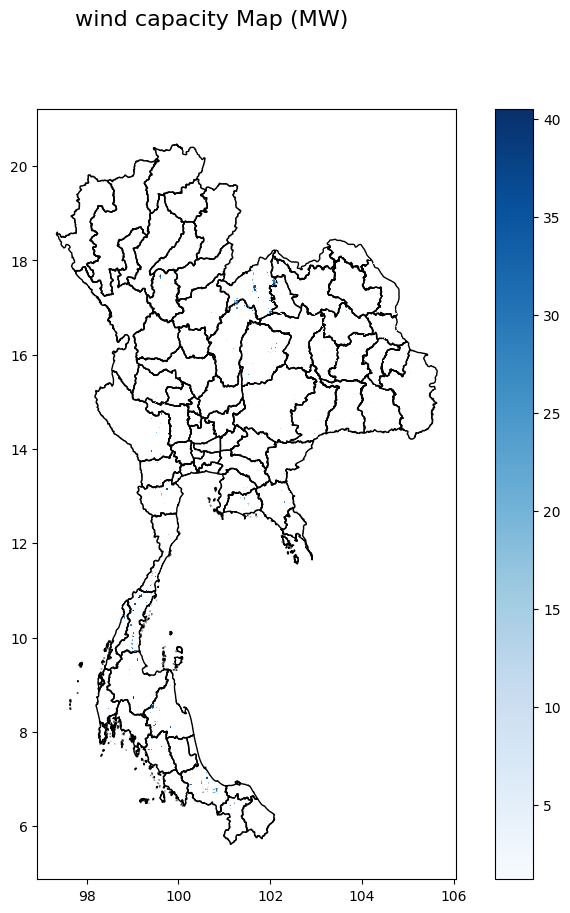

In [9]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

print("total wind capacity = ", df_wind['cap_wind'].sum())
print("R0 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R0'].sum())
print("R1 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R1'].sum())
print("R2 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R2'].sum())
print("R3 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R3'].sum())
print("R4 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('wind capacity Map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_wind.plot(ax = ax,legend=True,zorder = 1,column = 'cap_wind',cmap = 'Blues')
except:
    None

total solar capacity =  1200907.7
R0 Solar =  5128.999999999999
R1 Solar =  253544.69999999998
R2 Solar =  513712.10000000003
R3 Solar =  147060.5
R4 Solar =  281461.4


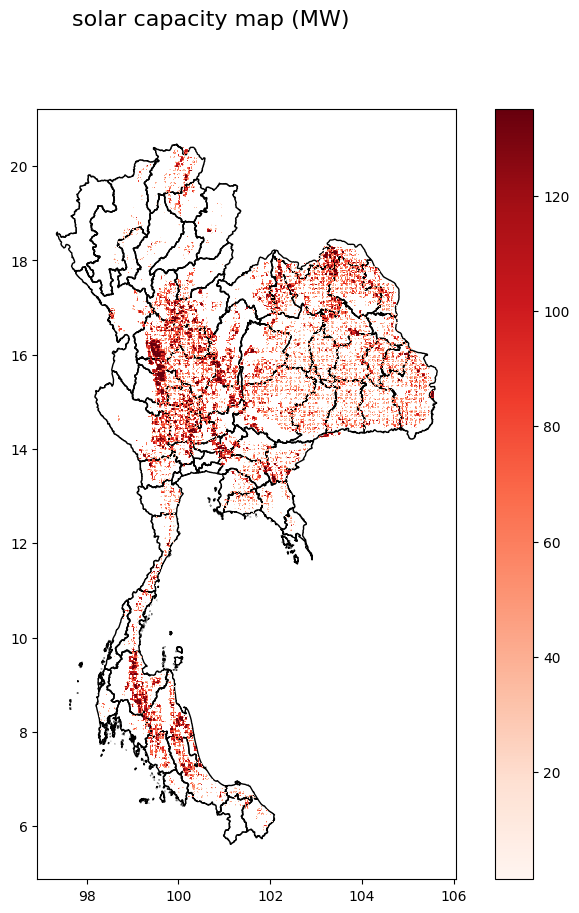

In [10]:
print("total solar capacity = ", df_solar['cap_solar'].sum())
print("R0 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R0'].sum())
print("R1 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R1'].sum())
print("R2 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R2'].sum())
print("R3 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R3'].sum())
print("R4 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('solar capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_solar.plot(ax = ax,legend=True,zorder = 1,column = 'cap_solar',cmap = 'Reds')
except:
    None


total biomass capacity =  2122.7
R0 biomass =  0.0
R1 biomass =  375.29999999999995
R2 biomass =  364.9
R3 biomass =  665.0
R4 biomass =  717.5


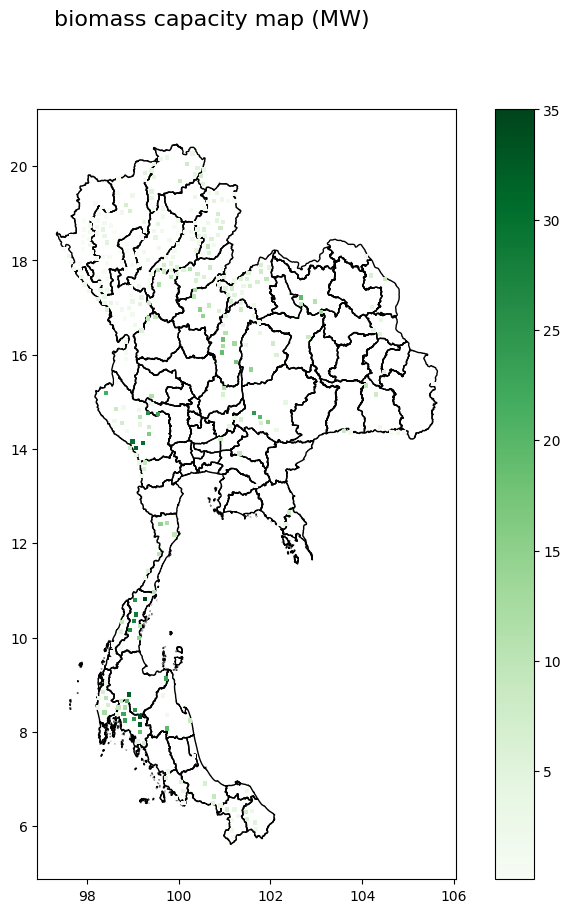

In [11]:
print("total biomass capacity = ", df_biomass['cap_biomass'].sum())
print("R0 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R0'].sum())
print("R1 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R1'].sum())
print("R2 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R2'].sum())
print("R3 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R3'].sum())
print("R4 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('biomass capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_biomass.plot(ax = ax,legend=True,zorder = 1,column = 'cap_biomass',cmap = 'Greens')
except:
    None

total bgec capacity =  0.0
R0 bgec =  0.0
R1 bgec =  0.0
R2 bgec =  0.0
R3 bgec =  0.0
R4 bgec =  0.0


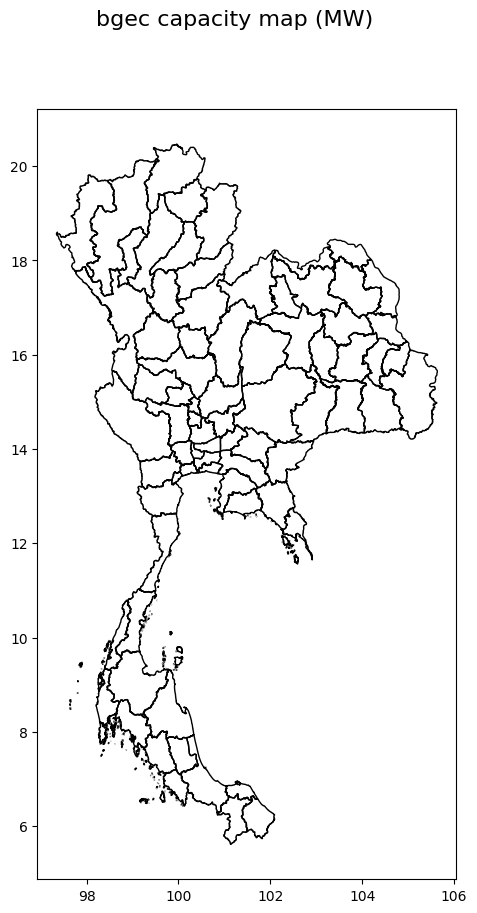

In [12]:
print("total bgec capacity = ", df_bgec['cap_bgec'].sum())
print("R0 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R0'].sum())
print("R1 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R1'].sum())
print("R2 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R2'].sum())
print("R3 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R3'].sum())
print("R4 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('bgec capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_bgec.plot(ax = ax,legend=True,zorder = 1,column = 'cap_bgec',cmap = 'Purples')
except:
    None

total msw capacity =  1866.0999999999997
R0 msw =  642.6999999999999
R1 msw =  524.5999999999999
R2 msw =  185.0
R3 msw =  257.8
R4 msw =  255.99999999999997


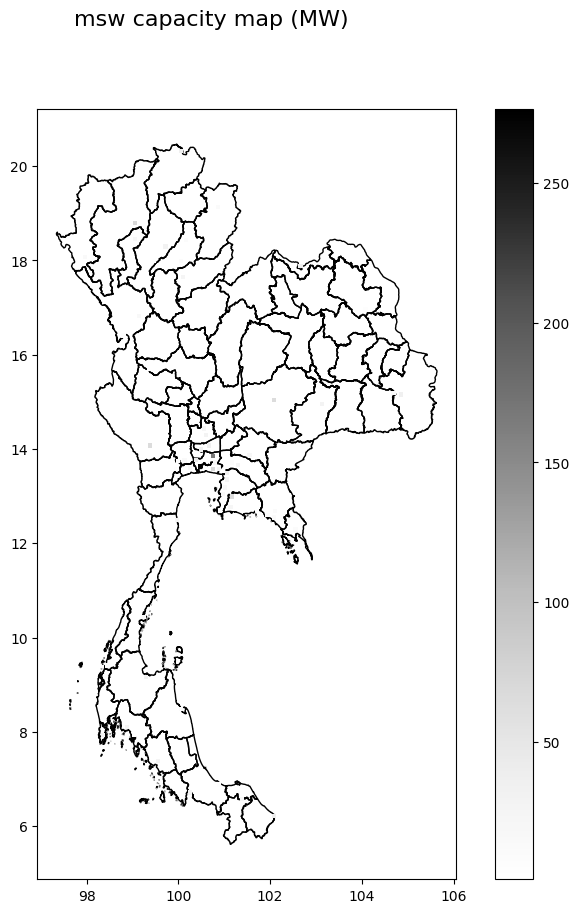

In [13]:
print("total msw capacity = ", df_msw['cap_msw'].sum())
print("R0 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R0'].sum())
print("R1 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R1'].sum())
print("R2 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R2'].sum())
print("R3 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R3'].sum())
print("R4 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('msw capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_msw.plot(ax = ax,legend=True,zorder = 1,column = 'cap_msw',cmap = 'Greys')
except:
    None

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


total wind capacity =  0.0
total solar capacity =  695.5000000000001
total biomass capacity =  0.0
total bgec capacity =  0.0
total msw capacity =  444.2


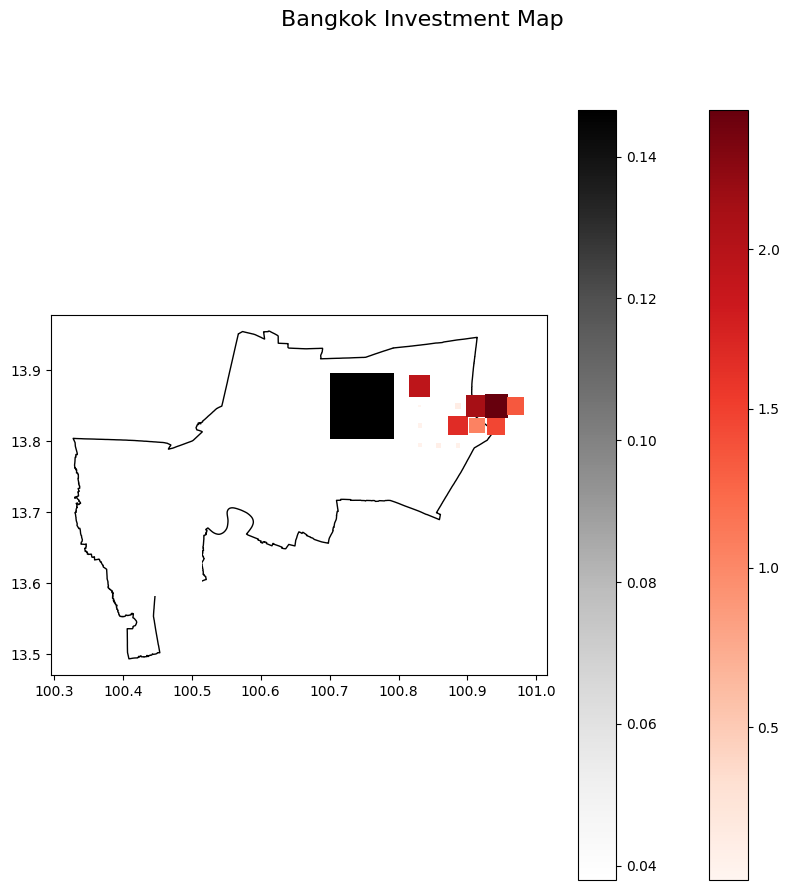

In [14]:
province = 'Bangkok'
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
specificarea = thailandmap.loc[thailandmap['ADM1_EN'] == province]
bound = specificarea.unary_union.bounds

print("total wind capacity = ", df_wind['cap_wind'].loc[df_wind['ADM1_EN'] == province].sum())

print("total solar capacity = ", df_solar['cap_solar'].loc[df_solar['ADM1_EN'] == province].sum())

print("total biomass capacity = ", df_biomass['cap_biomass'].loc[df_biomass['ADM1_EN'] == province].sum())

print("total bgec capacity = ", df_bgec['cap_bgec'].loc[df_bgec['ADM1_EN'] == province].sum())

print("total msw capacity = ", df_msw['cap_msw'].loc[df_msw['ADM1_EN'] == province].sum())


fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(province + ' Investment Map ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind.loc[df_wind['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 1,column = 'SI_Wind',cmap = 'Blues')
except:
    None
try:
    df_solar.loc[df_solar['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'SI_Solar',cmap = 'Reds')
except:
    None
try:
    df_biomass.loc[df_biomass['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'SI_Biomass',cmap = 'Greens')
except:
    None
try:
    df_bgec.loc[df_bgec['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'SI_BGEC',cmap = 'Purples')
except:
    None
try:
    df_msw.loc[df_msw['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'SI_MSW',cmap = 'Greys')
except:
    None



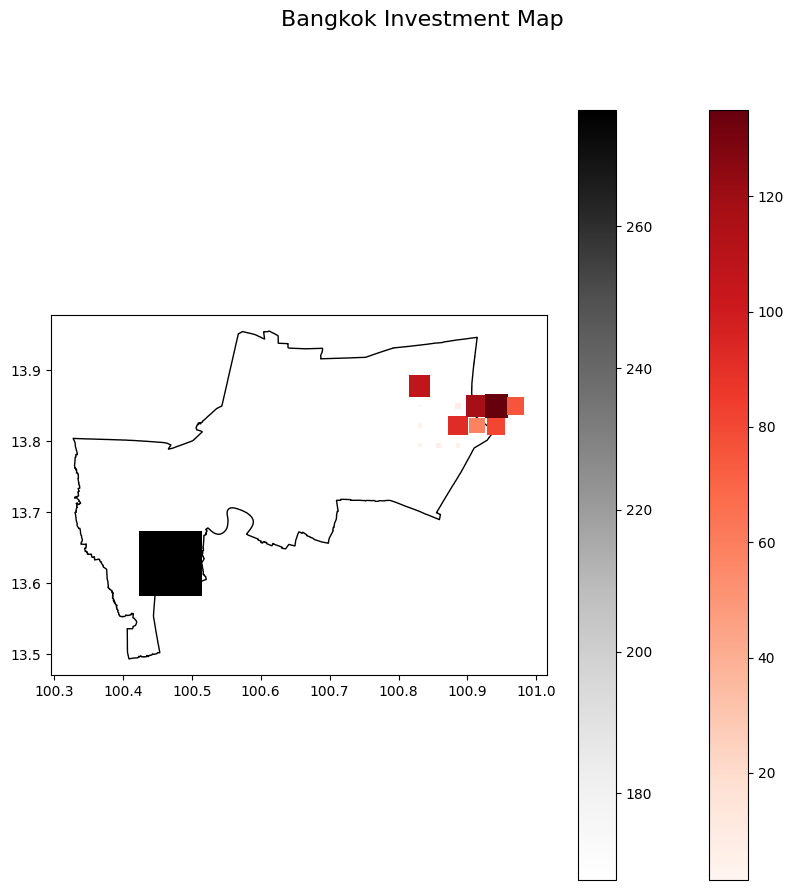

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(province + ' Investment Map ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind.loc[df_wind['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 1,column = 'cap_wind',cmap = 'Blues')
except:
    None
try:
    df_solar.loc[df_solar['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'cap_solar',cmap = 'Reds')
except:
    None
try:
    df_biomass.loc[df_biomass['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'cap_biomass',cmap = 'Greens')
except:
    None
try:
    df_bgec.loc[df_bgec['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'cap_bgec',cmap = 'Purples')
except:
    None
try:
    df_msw.loc[df_msw['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'cap_msw',cmap = 'Greys')
except:
    None
